In [1]:
import numpy as np
import os, pickle
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar, minimize_scalar
from scipy.ndimage import gaussian_filter
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.gridspec import GridSpec

from src.model import intensity
from src.theory import rate_fn, rate_fn_neg
from src.sim import sim_lif_perturbation, sim_lif_receptor_perturbation, sim_lif_perturbation_x, sim_lif_pop, create_spike_train
from src.phase_plane import dv, phase_plane_plot

In [2]:
from scripts import plot_fluctuations

from scripts.plot_exc_inh import *
from scripts.plot_uncoupled import *

In [3]:
%load_ext autoreload
%autoreload 2

## *Dynamics of Stochastic Integrate-and-Fire Networks*

In [309]:
J = 6
g = 0.3
E = 0.5

Ne = 200
Ni = 50
N = Ne + Ni
pE = 0.2
pI = 0.8

Jmat = np.zeros((N, N))
Jmat[:, :Ne] = np.random.binomial(n=1, p=pE, size=(N,Ne)) * J / pE / Ne
Jmat[:, Ne:] = np.random.binomial(n=1, p=pI, size=(N,Ni)) * (-g * J) / pI / Ni

tstop = 20
dt = .01
tplot = np.arange(0, tstop, dt)
perturb_amp = 2
perturb_len = 2

v, spktimes = sim_lif_perturbation(J=Jmat, E=E, tstop=tstop, dt=dt, perturb_len=perturb_len, perturb_amp=perturb_amp)

(250,)


(0.0, 20.0)

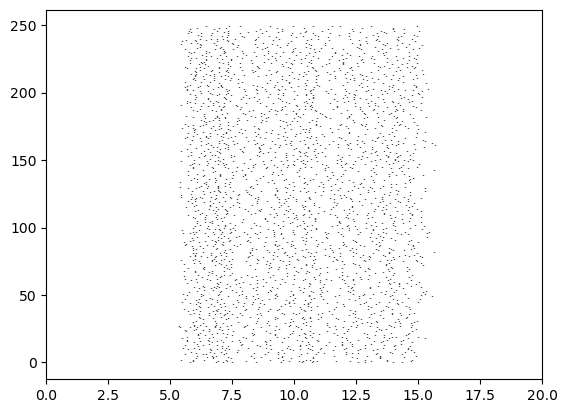

In [310]:
plt.plot(spktimes[:,0], spktimes[:,1], 'k|', markersize=0.5)
plt.xlim((0,tstop))

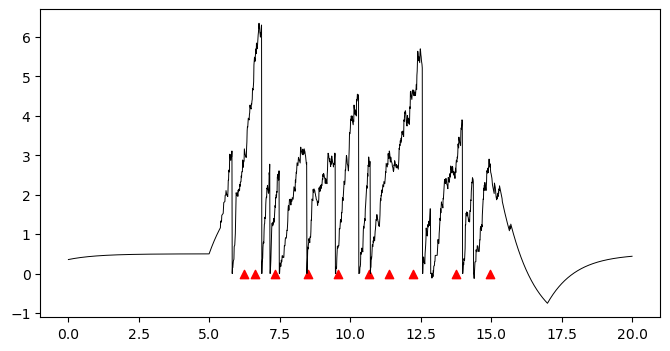

In [311]:
unit_0_spktimes = spktimes[spktimes[:,1] == 200.,0]
unit_0_spktimes

plt.figure(figsize=(8,4))
plt.plot(tplot, v[:,0], color='black', linewidth=0.7)
plt.scatter(unit_0_spktimes, np.repeat(0, len(unit_0_spktimes)), color='red', marker='^')

In [7]:
print(f"Resting Voltage:       {E}")
print(f"dt:                    {dt}")
print(f"Perturbation Length:   {perturb_len}")
print(f"Perturbation Amperage: {perturb_amp}")

Resting Voltage:       0.5
dt:                    0.01
Perturbation Length:   2
Perturbation Amperage: 2


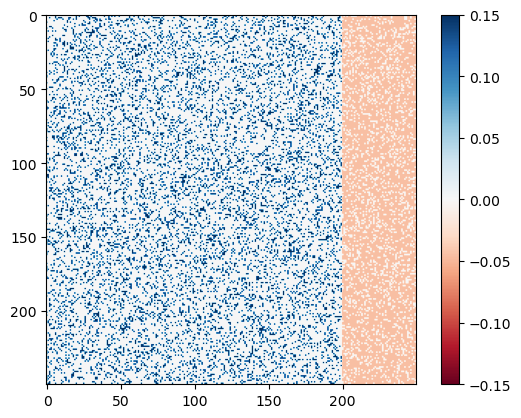

In [8]:
plt.imshow(Jmat, vmin=-0.15, vmax=0.15, cmap='RdBu')
plt.colorbar()

## Xiao-Jing Wang, *Probabilistic Decision-Making*

>The model combines a network architecture taken from Amit and Brunel (1997) and descriptions of synaptic currents from Wang (1999). The network is composed of $N$ neurons, with $N_E$ pyramidal cells (80%) and $N_I$ interneurons (20%) (Braitenberg and Schütz, 1991). It represents a local cortical circuit in the posterior parietal cortex. For the sake of clarity, I have used the simplest version of the model, with the assumption that the network encodes two stimulus directions (left or right). Each stimulus activates a distinct and small subpopulation of $fN_E$ excitatory cells ($f=0.15$). The remaining $(1-2f)N_E$ neurons do not respond to either of the stimuli. This is a simple realization of the common experimental protocol, where the physiological measurements aare done with the best and worst stimuli (preferred and null directions) of the recorded cell. Simulations reported in this paper were done with $N_E=1600$, $N_I=400$.

...

>Each neuron receives inputs from all other neurons, but with structured synaptic weights. The coupling strength between a pair of neurons is prescribed according to a "Hebbian" rule: the synapse is strong (weak) if in the past the two cells tended to be active in a correlated (anticorrelated) manner. Hence, inside a population, $w_j=w_+$, where $w_+ > 1$ is a dimensionless parameter that is equal to the relative strength of "potentiated" synapses with respect to the baseline. Unless specified otherwise, I used $w_+ = 1.7$. Between two different selective populations, and from the nonselective population to selective ones, $w_j=w_-$, where $w_- < 1$ measures the strength of synaptic "depression." Other connections have $w_j = 1$. It is assumed by synaptic modifications, because synaptic depression compensates the effect of potentiation at the network level. More specifically, by choosing $w_- = 1 - f(w_+ - 1)/(1-f)$, the overall recurrent excitatory synaptic drive in the spontaneous state remains constant as $w_+$ is varied (Amit and Brunel, 1997). Synaptic efficacies remain fixed through the simuation.

In [419]:
def create_connect_mat(J, g, Ne, Ni, pE, pI, f, wstrong, plot=False):
    N = Ne + Ni
    wweak = 1 - ((f*(wstrong - 1)) / (1 - f))
    fNe = int(f * Ne)

    Jmat = np.zeros((N, N))
    Jmat_exc = np.zeros((N, N))

    Jmat[:, :Ne] = np.random.binomial(n=1, p=pE, size=(N, Ne)) * J / pE / Ne
    Jmat[:, Ne:] = np.random.binomial(n=1, p=pI, size=(N, Ni)) * (-g * J) / pI / Ni

    # wj = 1
    Jmat_exc[:,:Ne] = 1 # from all excitatory to all else

    # wj = w+
    Jmat_exc[:fNe, :fNe] = wstrong # from selective A to selective A
    Jmat_exc[fNe:(2*fNe), fNe:(2*fNe)] = wstrong # from selective B to selective B

    # wj = w-
    Jmat_exc[fNe:(2*fNe), :fNe] = wweak # from selective A to selective B
    Jmat_exc[:fNe, fNe:(2*fNe)] = wweak # from selective B to selective A
    Jmat_exc[:(2*fNe),(2*fNe):Ne] = wweak # from nonselective to selective

    Jmat[:,:Ne] *= Jmat_exc[:,:Ne]

    Jmat_max = np.max(np.abs(Jmat))
    Jmat_emax = np.max(np.abs(Jmat_exc))

    if plot:
        fig, ax = plt.subplots(1,2, figsize=(8,4))
        ax[0].imshow(Jmat, vmin=-Jmat_max, vmax=Jmat_max, cmap='RdBu')
        ax[1].imshow(Jmat_exc[:,:Ne], vmin=-Jmat_emax, vmax=Jmat_emax, cmap='RdBu')

    return Jmat

XJW cortical network parameters:
- $V_{L}=-70 { mV}$
- $V_{th}=-50 { mV}$
- $V_{reset}=-55 { mV}$
- $C_{m}^{pyr}=0.5 { nF}$
- $C_{m}^{inh}=0.2 { nF}$
- $g_{L}^{pyr}=25{ nS}$
- $g_{L}^{inh}=20{ nS}$
- $\tau_{ref}^{pyr}=2{ mS}$
- $\tau_{ref}^{inh}=1{ mS}$
- $\tau_{m}^{pyr}=20{ mS}$ ($\tau_m=C_m / g_L$)
- $\tau_{m}^{inh}=10{ mS}$

LIF model:
$$
C_{m}\frac{dV(t)}{dt} = -g_{L}(V(t)-V_{L})-I_{syn}(t)
$$

$$
\frac{dV(t)}{dt}=-\frac{g_L}{C_m}(V(t)-V_L)-I_{syn}(t)
$$

$$
\frac{dV(t)}{dt}=-\frac{1}{\tau}(V(t)+V_L)-I_{syn}(t)
$$

Stochastic LIF model:
```
v[t] = v[t-1] + dt*(-v[t-1] + E) + J.dot(n)
```
$$
\frac{dV(t)}{dt}=-V(t)+E+\sum_{c}J_{c}n
$$

## Simulation

In [405]:
from src.sim import sim_lif_receptor_perturbation

In [420]:
J = 6
E = -0.7 # originally -70 mV
v_th = -0.5 # originally -50 mV
v_r = -0.55 # originally -55 mV
g = 0.2

Ne = 1600
Ni = 400
N = Ne + Ni
pE = 0.2
pI = 0.8
f = 0.15
wstrong = 1.7

tstop = 2
dt = .0001
tplot = np.arange(0, tstop, dt)
perturb_amp = 0.5
perturb_len = 0.2

g_l = np.zeros(N,)
g_l[:Ne] = 25 # pyramidal leak conductance
g_l[Ne:] = 20 # interneuron leak conductance

c_m = np.zeros(N,)
c_m[:Ne] = 0.5 # pyramidal membrane capacitance
c_m[Ne:] = 0.2 # interneuron membrane capacitance

tau_recep = {"ampa": 0.002, "nmda_rise": 0.002, "nmda_decay": 0.100, "gaba": 0.005}

g_rec = {"ampa": 0.05, "nmda": 0.165, "gaba": 1.0}

Vc = (0, -0.7)

EI_ratio = Ne,Ni

print(f"Exc. Connection Strength:          {J}")
print(f"Inh. Connection Strength Scale:    {g}")
print(f"Resting Voltage:                   {E}")
print(f"Voltage Threshold:                 {v_th}")
print(f"Voltage Reset:                     {v_r}")
print(f"Time Step:                         {dt}")
print(f"Perturbation Length:               {perturb_len}")
print(f"Perturbation Amperage:             {perturb_amp}")

Jmat = create_connect_mat(J, g, Ne, Ni, pE, pI, f, wstrong)

v, spktimes, I_syn, gating_vars  = sim_lif_receptor_perturbation(J=Jmat, E=E, g_l=g_l, c_m=c_m, tau_recep=tau_recep, g_rec=g_rec,
                                            Vc=Vc, EI_ratio=EI_ratio,tstop=tstop, dt=dt, B=100, v_th=v_th, v_r=v_r,
                                            perturb_len=perturb_len, perturb_amp=perturb_amp)

# plt.plot(spktimes[:,0], spktimes[:,1], 'k|', markersize=0.5)
# plt.xlim((0,20))
# plt.show()

Exc. Connection Strength:          6
Inh. Connection Strength Scale:    0.2
Resting Voltage:                   -0.7
Voltage Threshold:                 -0.5
Voltage Reset:                     -0.55
Time Step:                         0.0001
Perturbation Length:               0.2
Perturbation Amperage:             0.5
(2000,)


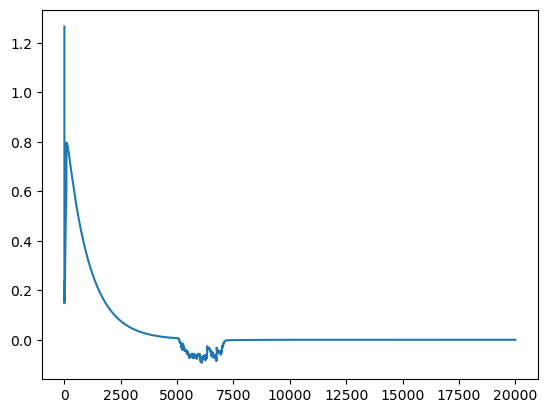

In [421]:
plt.plot(I_syn[:,467])
#plt.xlim((5000,7500))

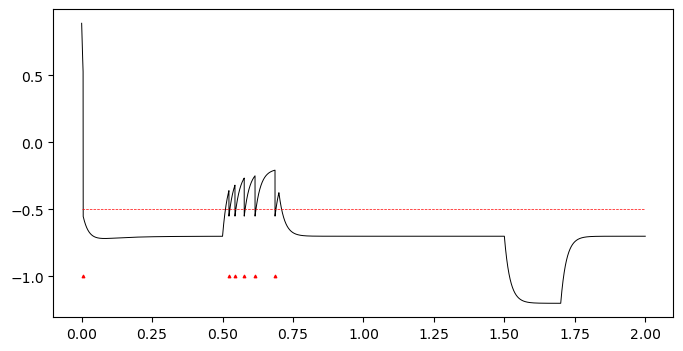

In [422]:
unit_idx = 300

unit_spktimes = spktimes[spktimes[:,1] == unit_idx,0]
unit_spktimes

plt.figure(figsize=(8,4))
plt.plot(tplot, v[:,unit_idx], color='black', linewidth=0.7)
plt.scatter(unit_spktimes, np.repeat(-1, len(unit_spktimes)), color='red', marker='^', s=3)
plt.hlines(v_th, xmin=0,xmax=2, linestyle='--', color='red', linewidth=0.5)
#plt.xlim(0.5,0.6)

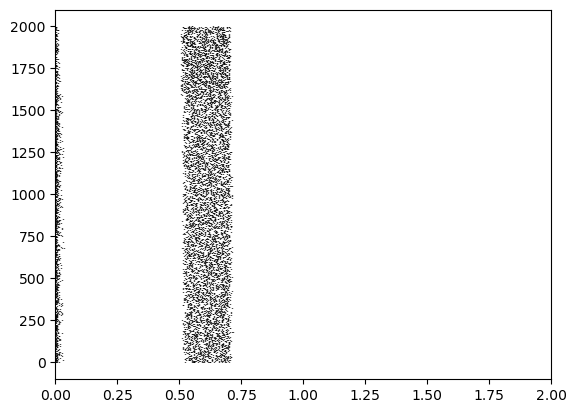

In [423]:
plt.plot(spktimes[:,0], spktimes[:,1], 'k|', markersize=0.5)
plt.xlim((0,tstop))
plt.show()

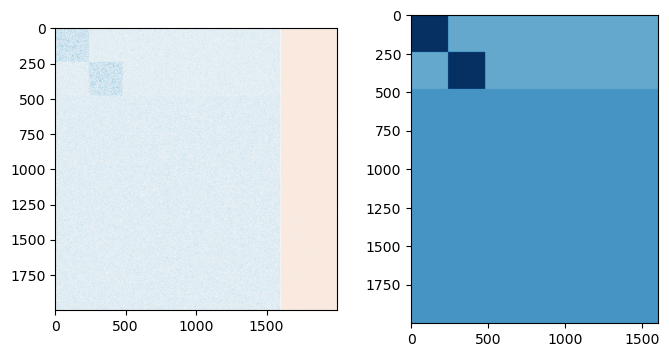

In [351]:
Jmat = create_connect_mat(J, 0.2, Ne, Ni, pE, pI, f, wstrong, plot=True)

In [413]:
np.min(Jmat)

np.float64(-0.0037500000000000007)

In [333]:
1 - (2/J)*(1 + np.sqrt(1-E))

np.float64(0.23205317298649009)